extraction of colour channels took 0:00:08.742451
optimisation of white channel took 0:00:00.213149
smoothing and contrast took 0:00:00.235546


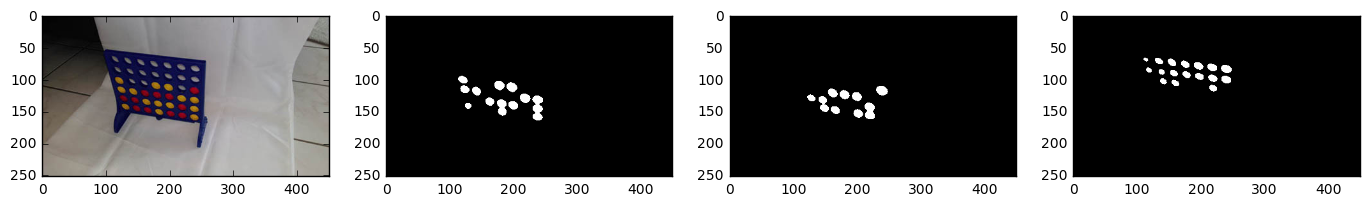

In [101]:
from skimage import io
from skimage.filters import gaussian, laplace, median
from skimage.morphology import disk
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

board = io.imread("board_images/board4.jpg") # values are optimised for images with a resolution of 450*252px (landscape)
# Note: first axis (0) runs downwards, second axis (1) runs to the right

# reference colours
yellow = [193,155,17]
red    = [156,10,25]
white  = [150,148,138]
blue   = [12,11,69]
tolerance = 50



# keep track of script runtime for different tasks
starttime = datetime.now()
def print_runtime(descr=""):
    global starttime
    print(descr, "took", datetime.now()-starttime)
    starttime = datetime.now()


# extract positions of the different game colours - this takes rather long (~9s)
# TODO: find a way of speeding this up: matrix multiplication with colour mask?
board_yellow = np.zeros_like(board[:,:,0])
board_red    = np.zeros_like(board[:,:,0])
board_white  = np.zeros_like(board[:,:,0])
board_blue   = np.zeros_like(board[:,:,0])

for x in range(board.shape[0]):
    for y in range(board.shape[1]):
        if   (np.all(np.fabs(board[x, y]-yellow) <= tolerance)): board_yellow[x,y] = 1
        elif (np.all(np.fabs(board[x, y]-red)    <= tolerance)): board_red[x,y]    = 1 
        elif (np.all(np.fabs(board[x, y]-white)  <= tolerance)): board_white[x,y]  = 1
        elif (np.all(np.fabs(board[x, y]-blue)   <= tolerance/2)): board_blue[x,y] = 1  # reduce tolerance here as this is only used as a negative mask
print_runtime("extraction of colour channels")                     
  
    
# optimisation of board_white: only count white pixels surrounded by blue ones, i.e. discard all pixels of the present board_white until a blue one is reached (from all four directions)
for x in range(board.shape[0]):
    blue_pos = np.nonzero(board_blue[x, :])[0]
    if (blue_pos.size >= 1):
        board_white[x, 0:blue_pos[0]] = 0 # from left
        board_white[x, blue_pos[-1]:board.shape[1]] = 0 # from right
    else: board_white[x, :] = 0 # completely delete the lines from board_white in which there is no blue at all
        
for y in range(board.shape[1]):
    blue_pos = np.nonzero(board_blue[:, y])[0]
    if (blue_pos.size >= 1):
        board_white[0:blue_pos[0], y] = 0 # from top
        board_white[blue_pos[-1]:board.shape[0], y] = 0 # from bottom
    else: board_white[:, y] = 0 # completely delete the lines from board_white in which there is no blue at all
        
# in order to account for the board stand, do the same for br->tl and bl->tr directions
# take lines of 45 degree angle to avoid Bresenham algorithm etc.
for offset in range(board.shape[1]-board.shape[0]): # bl->tr
    for x in range(board.shape[0]):
        if (board_blue[board.shape[0]-1-x, x] == 1): break
        else: board_white[board.shape[0]-1-x, x+offset] = 0
            
for offset in range(board.shape[1]-board.shape[0]): # br->tl
    for x in range(board.shape[0]):
        if (board_blue[board.shape[0]-x-1, x] == 1): break
        else: board_white[board.shape[0]-1-x, board.shape[1]-1-x-offset] = 0     

print_runtime("optimisation of white channel")


# add Gaussian smoothing            
board_yellow = gaussian(board_yellow, sigma=2)
board_red    = gaussian(board_red, sigma=2)
board_white  = gaussian(board_white, sigma=2)

# cut away low values below 95% brightness (i.e. increase contrast)
board_total = board_yellow + board_red + board_white
thresh = np.percentile(board_total, 95)
for board_current in [board_yellow, board_red, board_white]:
    for x in range(board_current.shape[0]):
        for y in range(board_current.shape[1]):
            if (board_current[x, y] < thresh): board_current[x, y] = 0
            else: board_current[x, y] = 1
print_runtime("smoothing and contrast")

plt.figure(figsize=(17, 5))
plt.subplot(141)
plt.imshow(board)
plt.subplot(142)
plt.imshow(board_yellow, cmap='gray')
plt.subplot(143)
plt.imshow(board_red, cmap='gray')
plt.subplot(144)
plt.imshow(board_white, cmap='gray')

plt.show()

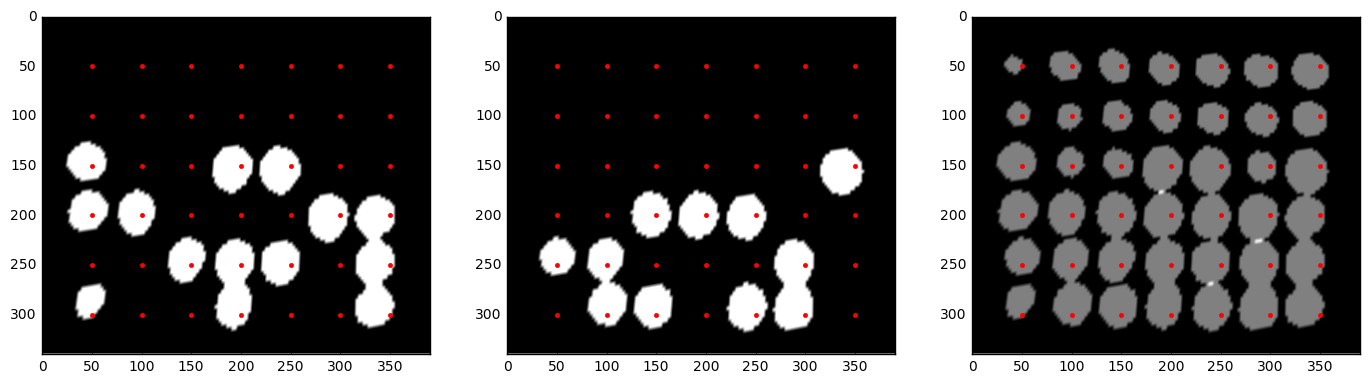

In [102]:
# transform to a square grid
from skimage import transform as tf

board_total = board_yellow+board_red+board_white

# mirror board against the y-axis
board_mirrored = np.copy(board_total)
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        board_mirrored[x, board_total.shape[1]-y-1] = board_total[x,y]
        
# for viewing angles which are not too steep, it should be sufficient to look for the bright points with smallest and biggest coordinate sum and treat these as top-left / bottom-right corner:
topleft = [board_total.shape[0], board_total.shape[1]]
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        if (board_total[x, y]>0 and x+y<topleft[0]+topleft[1]): 
            topleft[0] = x
            topleft[1] = y

botright = [0, 0]
for x in range(board_total.shape[0]):
    for y in range(board_total.shape[1]):
        if (board_total[x, y]>0 and x+y>botright[0]+botright[1]): 
            botright[0] = x
            botright[1] = y

# bottom-left and top-right can be obtained in the same way from the board which is mirrored on the y-axis:
topright = [board_mirrored.shape[0], board_mirrored.shape[1]]
for x in range(board_mirrored.shape[0]):
    for y in range(board_mirrored.shape[1]):
        if (board_mirrored[x, y]>0 and x+y<topright[0]+topright[1]): 
            topright[0] = x
            topright[1] = y
# invert mirroring
topright[1] = board_mirrored.shape[1]-topright[1]

botleft = [0, 0]
for x in range(board_mirrored.shape[0]):
    for y in range(board_mirrored.shape[1]):
        if (board_mirrored[x, y]>0 and x+y>botleft[0]+botleft[1]): 
            botleft[0] = x
            botleft[1] = y
# invert mirroring
botleft[1] = board_mirrored.shape[1]-botleft[1]            



# now, add constant margin and warp to square grid (image rectification using scikit-image):
margin = 40
dimensions = [350, 300] # this should be in the ratio 7:6 due to the board configuration

# src and dest are a bit counter-intuitive...  
src = np.array([[margin, margin], [margin, dimensions[1]], [dimensions[0], dimensions[1]], [dimensions[0], margin]])
dst = np.array([topleft[ : :-1],  botleft[ : :-1],         botright[ : :-1],               topright[ : :-1]]) # coordinates have to be flipped here - TODO: Why??

transf = tf.ProjectiveTransform()
transf.estimate(src, dst) # look for transformation transforming src to dst, i.e. the inverse transformation from dst to src
board_total_warped = tf.warp(board_total, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))
board_yellow_warped = tf.warp(board_yellow, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))
board_red_warped = tf.warp(board_red, transf, output_shape=(dimensions[1]+margin, dimensions[0]+margin))


# set up grid to extract colour information
grid = np.array([[50*(i+1), 50*(6-j)] for i in range(7) for j in range(6)])
        

plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow(board_yellow_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(132)
plt.imshow(board_red_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(133)
plt.imshow(board_total_warped, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.show()

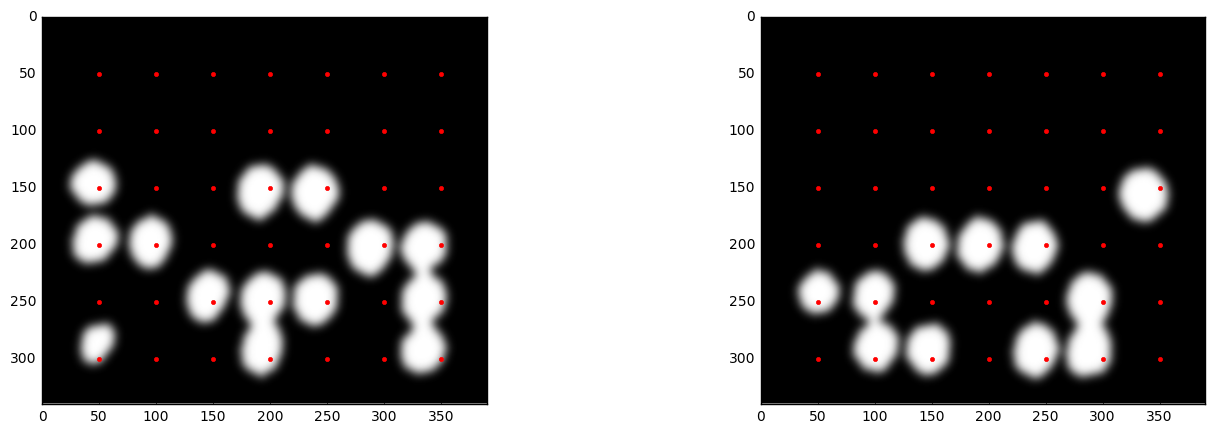

Valid game configuration extracted:


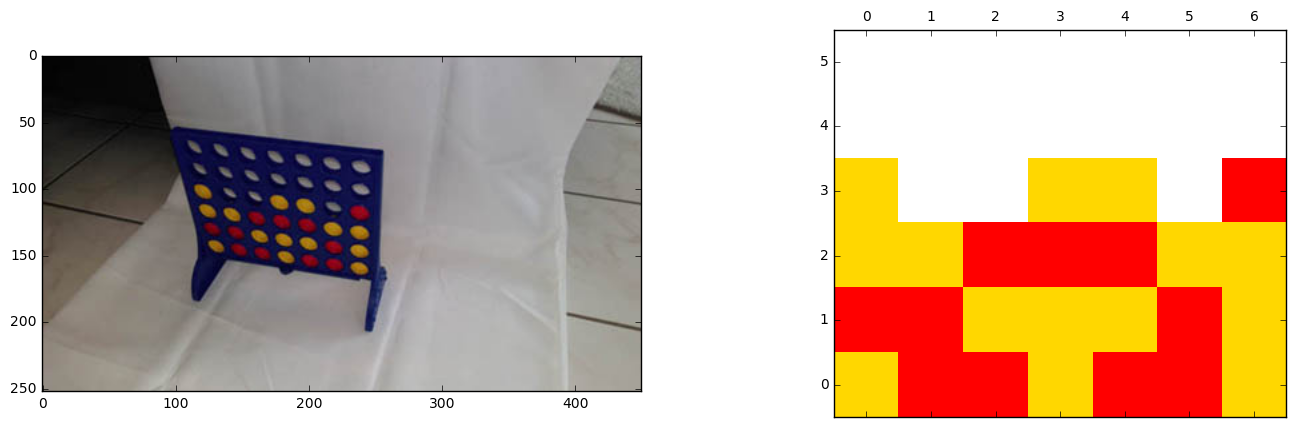

In [120]:
from matplotlib.colors import ListedColormap

# function to test whether a given board configuration is valid according to gravity
def is_valid(boardconfig):
    for row in range(6-1):
        for col in range(7):
            if (boardconfig[row, col] == 1 and boardconfig[row+1, col] != 1): return False
    return True



# extract colour information
boardconfig = np.ones([6,7]) # six rows, seven columns                                    #1 for free slot (white)

# add an extra Gaussian smoothing in case the spots don't end up perfectly on the grid points:
board_yellow_warped_smoothed = gaussian(board_yellow_warped, sigma=4)
board_red_warped_smoothed    = gaussian(board_red_warped,    sigma=4)

plt.figure(figsize=(17,5))
plt.subplot(121)
plt.imshow(board_yellow_warped_smoothed, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.subplot(122)
plt.imshow(board_red_warped_smoothed, cmap='gray')
plt.plot(grid[:,0], grid[:,1], '.r')
plt.xlim(0,dimensions[0]+margin)
plt.ylim(dimensions[1]+margin,0)
plt.show()

for i, pos in enumerate(grid):
    if (board_yellow_warped_smoothed[pos[1], pos[0]] > 1e-3): boardconfig[i%6, i//6] = 0 #0 for yellow
    elif (board_red_warped_smoothed[pos[1], pos[0]]  > 1e-3): boardconfig[i%6, i//6] = 2 #2 for red


if (is_valid(boardconfig)): 
    print("Valid game configuration extracted:")
    # draw board and original photograph for comparison:
    colormap = ListedColormap(['gold', 'white', 'red'])
    fig = plt.figure(figsize=(17,5))
    plt1 = fig.add_subplot(121)
    plt1.imshow(board)
    plt2 = fig.add_subplot(122)
    plt2.matshow(boardconfig, cmap=colormap)
    plt.gca().invert_yaxis()
    plt.show()
else:
    print("No valid game board could be extracted. Please retake photograph.")